<a href="https://colab.research.google.com/github/Mnikito/4106/blob/main/ASL_Recognition/ASL_MobileNetV2_Training_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install torchvision and kaggle
!pip install torchvision
!pip install kaggle

In [2]:
# download dataset and extract it
! export KAGGLE_USERNAME="michealnikitin" && export KAGGLE_KEY="12287a73a5ea9f40a4901060014566ab" && kaggle datasets download --unzip amarinderplasma/alphabets-sign-language
! ls

100% 2.04G/2.05G [00:12<00:00, 295MB/s]
100% 2.05G/2.05G [00:12<00:00, 172MB/s]
asl_alphabet_1	   asl_alphabet_train  sample_data
asl_alphabet_test  asl_alphabet_valid


In [3]:
! pwd && ls
print("\nFolders(classess) in training folder: ...")
! cd asl_alphabet_1/asl_alphabet_train && ls

/content
asl_alphabet_1	   asl_alphabet_train  sample_data
asl_alphabet_test  asl_alphabet_valid

Folders(classess) in training folder: ...
A  C  del  F  H  J  L  N	O  Q  S      T	V  X  Z
B  D  E    G  I  K  M  nothing	P  R  space  U	W  Y


In [4]:
#import  needed libraries and check the used gpu
import torch
from torch import nn,optim
from torchvision import transforms, models ,datasets
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid

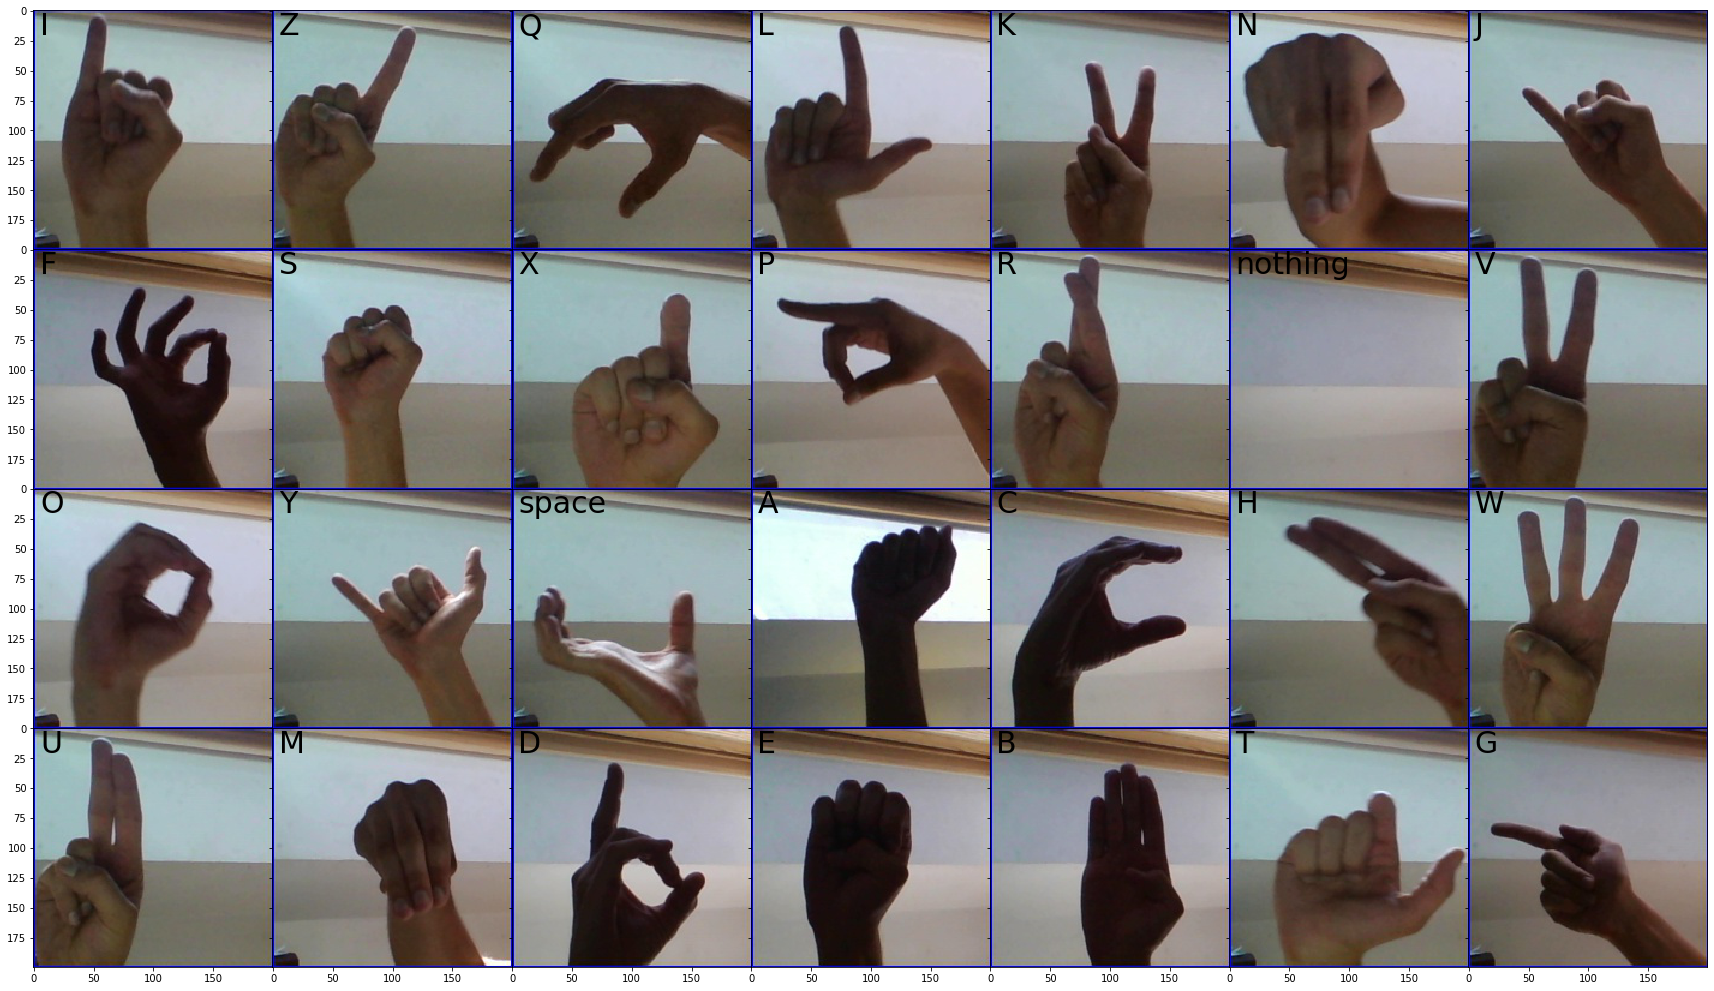

In [5]:
%matplotlib inline

ASL=np.array(glob.glob('asl_alphabet_test/*')) 

fig = plt.figure(figsize=(30, 30))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(4, 7),  
                 axes_pad=0,  # pad between axes in inch.
                 )
l=0
for img in ASL:
        im=plt.imread(img)
        grid[l].imshow(im,cmap='gray',interpolation='nearest')
        grid[l].text(5,20, img.split('/')[1].split('_')[0] ,fontsize=30)
        l+=1

In [9]:
#creating the dataloaders 

# Define transforms for the training data and testing data
train_path='asl_alphabet_1/asl_alphabet_train'
valid_path='asl_alphabet_1/asl_alphabet_valid'

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomInvert(0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [10]:
# load data to loaders
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(valid_path, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=512)

#print used Device
print(f"Device used: {torch.cuda.get_device_name(0)}")

#print class to index mapping
print(f"class to index mapping: {train_data.class_to_idx}")

Device used: Tesla T4
class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [11]:
# choose a pretrained model to start with check options here: https://pytorch.org/docs/stable/torchvision/models.html
model = models.mobilenet_v2(pretrained=True)

# Freeze parameters of the tarined network 
for param in model.parameters():
    param.requires_grad = False
    
#print the model to check the classifer and change it
print (model.classifier)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [12]:
# define new classifier and append it to network but remember to have a 29-neuron output layer for our two classes.
model.classifier= nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                nn.Linear(in_features=1280, out_features=29, bias=True),
                                nn.LogSoftmax(dim=1))

# unlock last three blocks before the classifier(last layer).
for p in model.features[-3:].parameters():
    p.requires_grad = True  

    
# choose your loss function
criterion = nn.NLLLoss()

# define optimizer to train only the classifier and the previous three block.
optimizer = optim.Adam([{'params':model.features[-1].parameters()},
                        {'params':model.features[-2].parameters()},
                        {'params':model.features[-3].parameters()},
                        {'params':model.classifier.parameters()}], lr=0.0005)

# define Learning Rate scheduler to decrease the learning rate by multiplying it by 0.1 after each epoch on the data.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

#print the classifier now
print(model.classifier)

#print the whole model
# print(model)

Sequential(
  (0): Dropout(p=0.6, inplace=False)
  (1): Linear(in_features=1280, out_features=29, bias=True)
  (2): LogSoftmax(dim=1)
)


In [13]:
#Define number of epochs through data and run the training loop
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 3
step = 0
running_loss = 0
print_every = 5
trainlossarr=[]
testlossarr=[]
oldacc=0

steps=math.ceil(len(train_data)/(trainloader.batch_size))

In [15]:
%%time

for epoch in range(epochs):
    print(f"--------------------------------- START OF EPOCH [ {epoch+1} ] >>> LR =  {optimizer.param_groups[-1]['lr']} ---------------------------------\n")
    for inputs, labels in trainloader:
        model.train()
        step += 1
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        props = model.forward(inputs)
        loss = criterion(props, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step % print_every == 0) or (step==steps):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(props)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
 
                    
                        

            print(f"Epoch ({epoch+1} of {epochs}) ... "
                  f"Step  ({step:3d} of {steps}) ... "
                  f"Train loss: {running_loss/print_every:.3f} ... "
                  f"Test loss: {test_loss/len(testloader):.3f} ... "
                  f"Test accuracy: {accuracy/len(testloader):.3f} ")
            trainlossarr.append(running_loss/print_every)
            testlossarr.append(test_loss/len(testloader))
            running_loss = 0
            
        
    scheduler.step()
    step=0

--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.0005 ---------------------------------

Epoch (1 of 2) ... Step  (  5 of 142) ... Train loss: 3.315 ... Test loss: 2.854 ... Test accuracy: 0.312 
Epoch (1 of 2) ... Step  ( 10 of 142) ... Train loss: 2.717 ... Test loss: 2.022 ... Test accuracy: 0.532 
Epoch (1 of 2) ... Step  ( 15 of 142) ... Train loss: 2.078 ... Test loss: 1.412 ... Test accuracy: 0.649 
Epoch (1 of 2) ... Step  ( 20 of 142) ... Train loss: 1.558 ... Test loss: 1.053 ... Test accuracy: 0.750 
Epoch (1 of 2) ... Step  ( 25 of 142) ... Train loss: 1.228 ... Test loss: 0.840 ... Test accuracy: 0.785 
Epoch (1 of 2) ... Step  ( 30 of 142) ... Train loss: 0.980 ... Test loss: 0.693 ... Test accuracy: 0.848 
Epoch (1 of 2) ... Step  ( 35 of 142) ... Train loss: 0.762 ... Test loss: 0.584 ... Test accuracy: 0.883 
Epoch (1 of 2) ... Step  ( 40 of 142) ... Train loss: 0.656 ... Test loss: 0.512 ... Test accuracy: 0.897 
Epoch (1 of 2) ... Step  ( 45 of 142)

In [17]:
torch.save(model.state_dict(), 'MobileNetV2_ASL_V2.pt')

In [36]:
import collections
val_loader = torch.utils.data.DataLoader(test_data, batch_size=512)

correct = 0
total = 0

device = torch.device("cuda")
model = model.to(device = device)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=512, shuffle=False)

all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.99
Accuracy val: 0.97


In [37]:
pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=a77c5d105f34f9afb675a8d3f688e3136b482e93e290684c9d1985c1599b5362
  Stored in directory: /root/.cache/pip/wheels/c8/71/2f/92426c1ef33fb2e275b533878d8378f91c7f26846d9669019c
Successfully built ptflops


In [38]:
pip install --upgrade git+https://github.com/sovrasov/flops-counter.pytorch.git

  Cloning https://github.com/sovrasov/flops-counter.pytorch.git to /tmp/pip-req-build-4lxdieqc
  Running command git clone -q https://github.com/sovrasov/flops-counter.pytorch.git /tmp/pip-req-build-4lxdieqc


In [39]:
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  net = model
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

MobileNetV2(
  1.24 M, 100.000% Params, 318.99 MMac, 100.000% MACs, 
  (features): Sequential(
    1.21 M, 97.012% Params, 318.96 MMac, 99.988% MACs, 
    (0): ConvNormActivation(
      0, 0.000% Params, 12.04 MMac, 3.775% MACs, 
      (0): Conv2d(0, 0.000% Params, 10.84 MMac, 3.398% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(0, 0.000% Params, 802.82 KMac, 0.252% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0, 0.000% Params, 401.41 KMac, 0.126% MACs, inplace=True)
    )
    (1): InvertedResidual(
      0, 0.000% Params, 11.64 MMac, 3.649% MACs, 
      (conv): Sequential(
        0, 0.000% Params, 11.64 MMac, 3.649% MACs, 
        (0): ConvNormActivation(
          0, 0.000% Params, 4.82 MMac, 1.510% MACs, 
          (0): Conv2d(0, 0.000% Params, 3.61 MMac, 1.133% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(0, 0.000%